# Heart Failure Prediction (Predykcja niewydolności serca)

> This project was done for SKN Data Science by Zofia Seweryńska.

Project was done using the following dataset from Kaggle:

**Dataset:**  
[Kaggle Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) <br>
It consists 11 clinical features for predicting heart disease events: <br>
Age: wiek pacjenta [lata]<br>
Sex: płeć pacjenta [M: mężczyzna, F: kobieta]<br>
ChestPainType: rodzaj bólu w klatce piersiowej [TA: typowa dławica piersiowa, ATA: atypowa dławica piersiowa, NAP: ból nie-dławicowy, ASY: bezobjawowy]<br>
RestingBP: ciśnienie tętnicze spoczynkowe [mm Hg]<br>
Cholesterol: stężenie cholesterolu w surowicy [mg/dl]<br>
FastingBS: poziom glukozy na czczo [1: jeśli > 120 mg/dl, 0: w przeciwnym razie]<br>
RestingECG: wynik spoczynkowego EKG [Normal: prawidłowy, ST: nieprawidłowości odcinka ST-T (inwersja załamka T i/lub uniesienie lub obniżenie ST > 0,05 mV), LVH: przerost lewej komory wg kryteriów Estesa]<br>
MaxHR: maksymalne osiągnięte tętno [wartość liczbowa między 60 a 202]<br>
ExerciseAngina: dławica wysiłkowa [Y: tak, N: nie]<br>
Oldpeak: obniżenie odcinka ST (ang. oldpeak) [wartość liczbowa w mm]
ST_Slope: nachylenie odcinka ST podczas wysiłku [Up: wznoszące, Flat: płaskie, Down: opadające]<br>
HeartDisease: klasa wyjściowa [1: choroba serca, 0: brak choroby]<br>


## 1. Pre-processing of the Data Set
Here data set will be analyzed and important features will be described.

### 1.1 Importing Libraries

In [2]:
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
import statistics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

### 1.2 Kaggle Data Set Download

In [3]:
# os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\zosia\.kaggle'
# !kaggle datasets download -d fedesoriano/heart-failure-prediction -p heart_failure_data
# with zipfile.ZipFile("heart_failure_data/heart-failure-prediction.zip", 'r') as zip_ref:
#     zip_ref.extractall("heart_failure_data")

### 1.3 Data Extraction

In [3]:
#extracting data
df = pd.read_csv("heart_failure_data/heart.csv")
df_original = df.copy()


#Handling missing values 
print("Data quality check:")
print(f"Cholesterol = 0 (missing): {(df['Cholesterol'] == 0).sum()} patients")
print(f"RestingBP = 0 (missing): {(df['RestingBP'] == 0).sum()} patients")

# Replace 0s with NaN
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
df['RestingBP'] = df['RestingBP'].replace(0, np.nan)

# Nan with median
df = df.fillna({'Cholesterol': df['Cholesterol'].median(), 
                'RestingBP': df['RestingBP'].median()})

print(f"After - Missing values: {df.isnull().sum().sum()}")

fasting = df['FastingBS'].value_counts(normalize=True) 
resting = df['RestingECG'].value_counts(normalize=True)

Data quality check:
Cholesterol = 0 (missing): 172 patients
RestingBP = 0 (missing): 1 patients
After - Missing values: 0


### 1.4 One Hot Encoding
<div class="alert alert-block alert-info">
Explanation: <strong>One Hot Encoding</strong> is a method for converting categorical variables into a binary format. It creates new columns for each category where 1 means the category is present and 0 means it is not. 
</div>

In [4]:
# Make sure you're working with the right dataframe
print("Before encoding:", df.columns.tolist())

# One-hot encoding
categorical_features = ["ChestPainType", "ST_Slope", "RestingECG"]
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

print("After encoding:", df.columns.tolist())


Before encoding: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
After encoding: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'ST_Slope_Flat', 'ST_Slope_Up', 'RestingECG_Normal', 'RestingECG_ST']


### 1.5 Mapping the binary columns

In [5]:
# Numerical binary columns
df["Sex"] = df["Sex"].map({"M": 0, "F": 1})
df["ExerciseAngina"] = df["ExerciseAngina"].map({"N": 0, "Y": 1})

### 1.6 Standarizing the data
The standard score (z-score) is calculated as:

$$
z = \frac{x - \text{mean}}{\text{standard deviation}}
$$

- *Continuous variables:* (Age, RestingBP, Cholesterol, MaxHR, Oldpeak) should be **standardized** using z-score normalization.
- *Categorical features:* (Sex, ChestPainType, ST_Slope, ExerciseAngina, etc.) should be left *numeric* but **not standardized**.

In [6]:
def standardize_features(columns):
    for column in columns:
        mean = df[column].mean()
        std = df[column].std()
        df[column] = (df[column] - mean) / std
    return df
columns_to_standardize = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

df = standardize_features(columns_to_standardize)

print(df.head())

bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)


        Age  Sex  RestingBP  Cholesterol  FastingBS     MaxHR  ExerciseAngina  \
0 -1.432359    0   0.414776     0.857567          0  1.382175               0   
1 -0.478223    1   1.526497    -1.183582          0  0.753746               0   
2 -1.750404    0  -0.141084     0.745211          0 -1.524307               0   
3 -0.584238    1   0.303604    -0.546893          0 -1.131539               1   
4  0.051853    0   0.970636    -0.902690          0 -0.581664               0   

    Oldpeak  HeartDisease  ChestPainType_ATA  ChestPainType_NAP  \
0 -0.831979             0               True              False   
1  0.105606             1              False               True   
2 -0.831979             0               True              False   
3  0.574398             1              False              False   
4 -0.831979             0              False               True   

   ChestPainType_TA  ST_Slope_Flat  ST_Slope_Up  RestingECG_Normal  \
0             False          False      

## 2. Analysis of the Data Set

### 2.1 Countplot

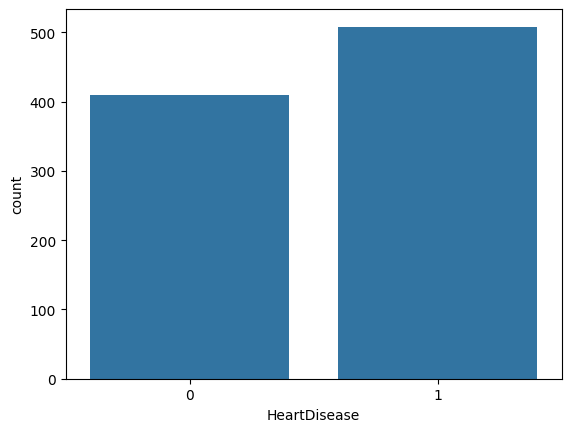

In [7]:
sns.countplot(x = "HeartDisease", data = df)
plt.show()

500 people have Heart Disease in our data and over 400 don’t have.

### 2.2 Heatmap

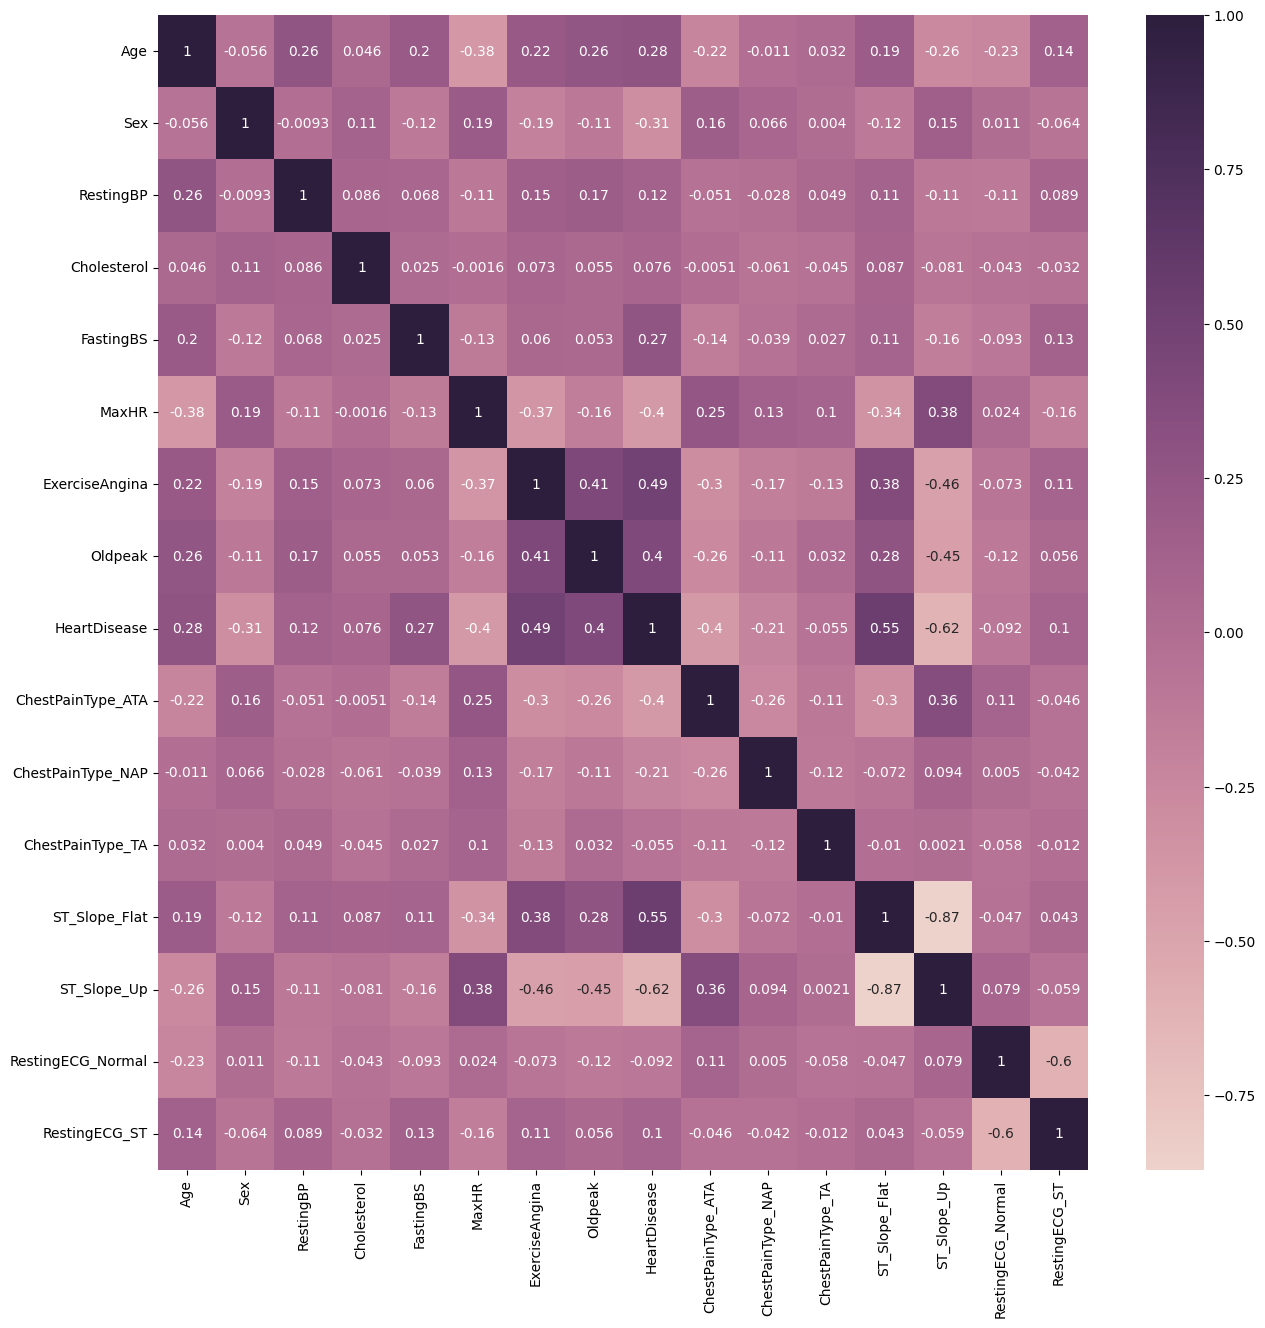

In [8]:
plt.figure(figsize=(15,15))
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

<div class="alert alert-block alert-info">
<strong>Correlation:</strong> The closer to 1 or -1, the stronger the relationship.


<table>
  <tr>
    <th>Value</th>
    <th>Range</th>
    <th>Meaning</th>
  </tr>
  <tr>
    <td>+1.0</td>
    <td>Perfect positive correlation</td>
    <td>When A increases, B increases exactly</td>
  </tr>
  <tr>
    <td>0</td>
    <td>No correlation</td>
    <td>A and B are not related</td>
  </tr>
  <tr>
    <td>-1.0</td>
    <td>Perfect negative correlation</td>
    <td>When A increases, B decreases exactly</td>
  </tr>
</table>
</div>


### Meaningful Relationships in the Dataset

**For Heart Disease:**  
- ST_Slope ↔ HeartDisease  
- OldPeak ↔ HeartDisease  
- ChestPainType ↔ HeartDisease  
- MaxHR ↔ HeartDisease  
- ExerciseAngina ↔ HeartDisease  
- Sex ↔ HeartDisease  

**For ST_Slope:**  
- ChestPainType ↔ ST_Slope  
- MaxHR ↔ ST_Slope  
- ExerciseAngina ↔ ST_Slope  
- OldPeak ↔ ST_Slope  

**For OldPeak:**  
- ChestPainType ↔ OldPeak  
- ChestPainType ↔ ExerciseAngina  

**For ChestPainType:**  
- MaxHR ↔ ChestPainType  
- ExerciseAngina ↔ ChestPainType  

**For MaxHR:**  
- Age ↔ MaxHR  

**Less important features:**  
- RestingECG  
- FastingBS  
- Cholesterol  
- RestingBP


### 2.3 Histogram


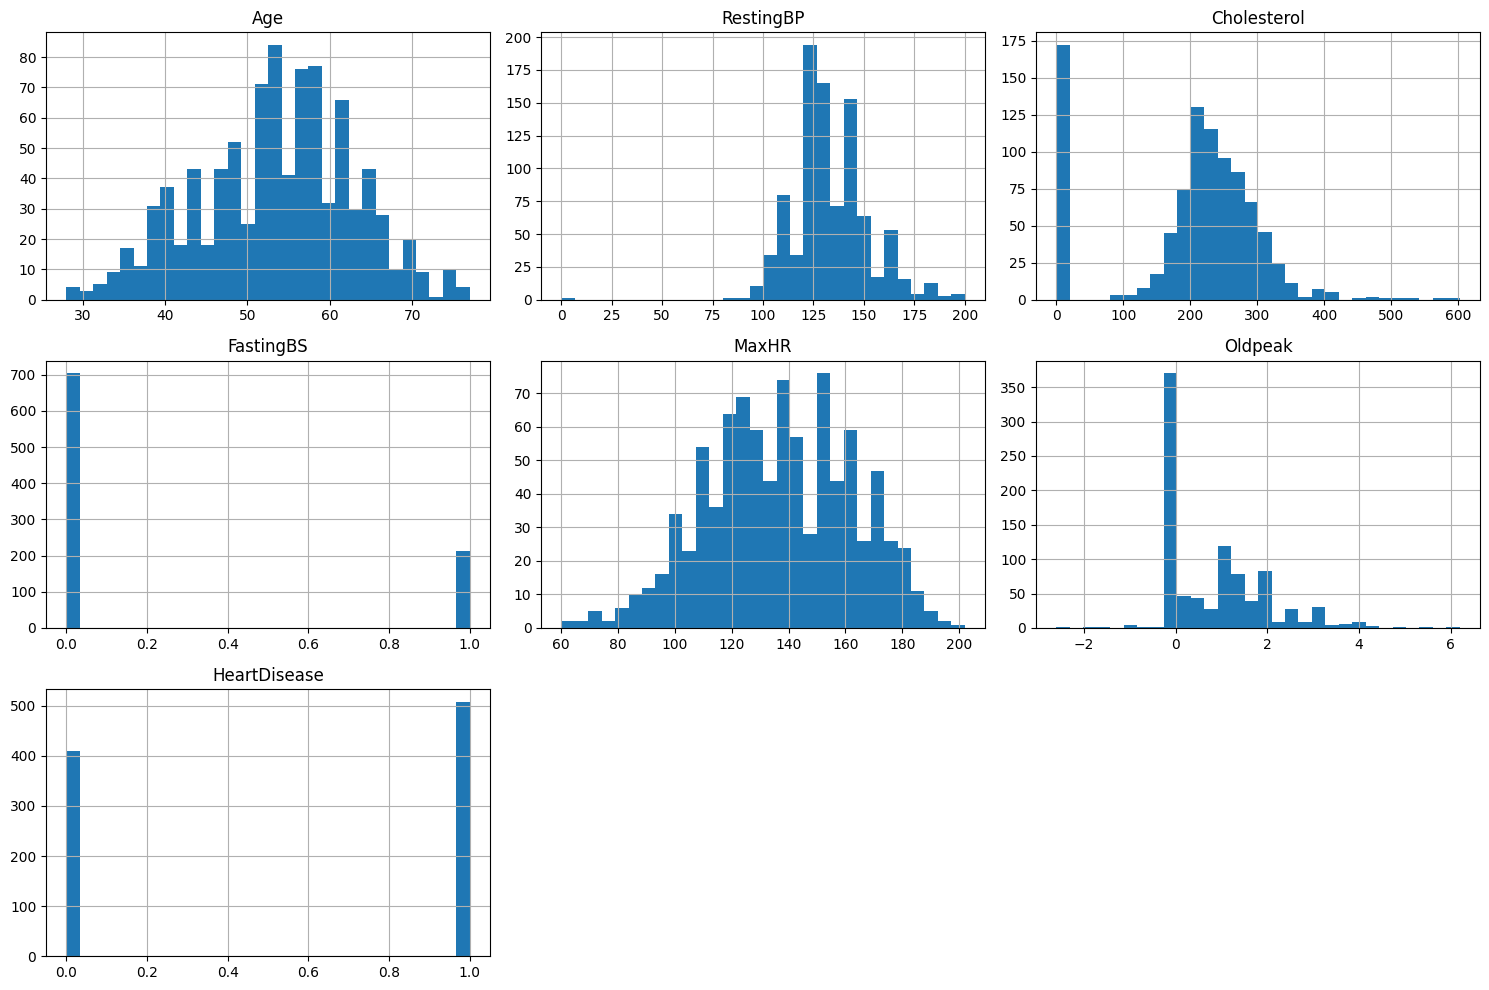

In [9]:
# Use original data for histograms
df_original.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<h4>Histogram Analysis</h4>

<strong>Continuous Variables:</strong><br>
- <strong>Age:</strong> Representative sample across age groups.<br>
- <strong>RestingBP:</strong> Normal distribution Issue:</strong> Spike at 0 indicates missing values.<br>
- <strong>Cholesterol:</strong> <strong>Major Issue:</strong> Large spike at 0 (~175 patients) represents missing data.<br>
- <strong>MaxHR:</strong> Normal distribution centered at 140-150bpm<br>
- <strong>Oldpeak:</strong> Values near 0. Most patients have minimal ST depression.<br><br>

<strong>Binary Variables:</strong><br>
- <strong>FastingBS:</strong> Heavily imbalanced - 700+ normal (0), ~200 elevated (1)<br>
- <strong>HeartDisease:</strong> Well balanced - ~400 without, ~500 with heart disease.<br><br>

</div>

### 2.4 Boxplot

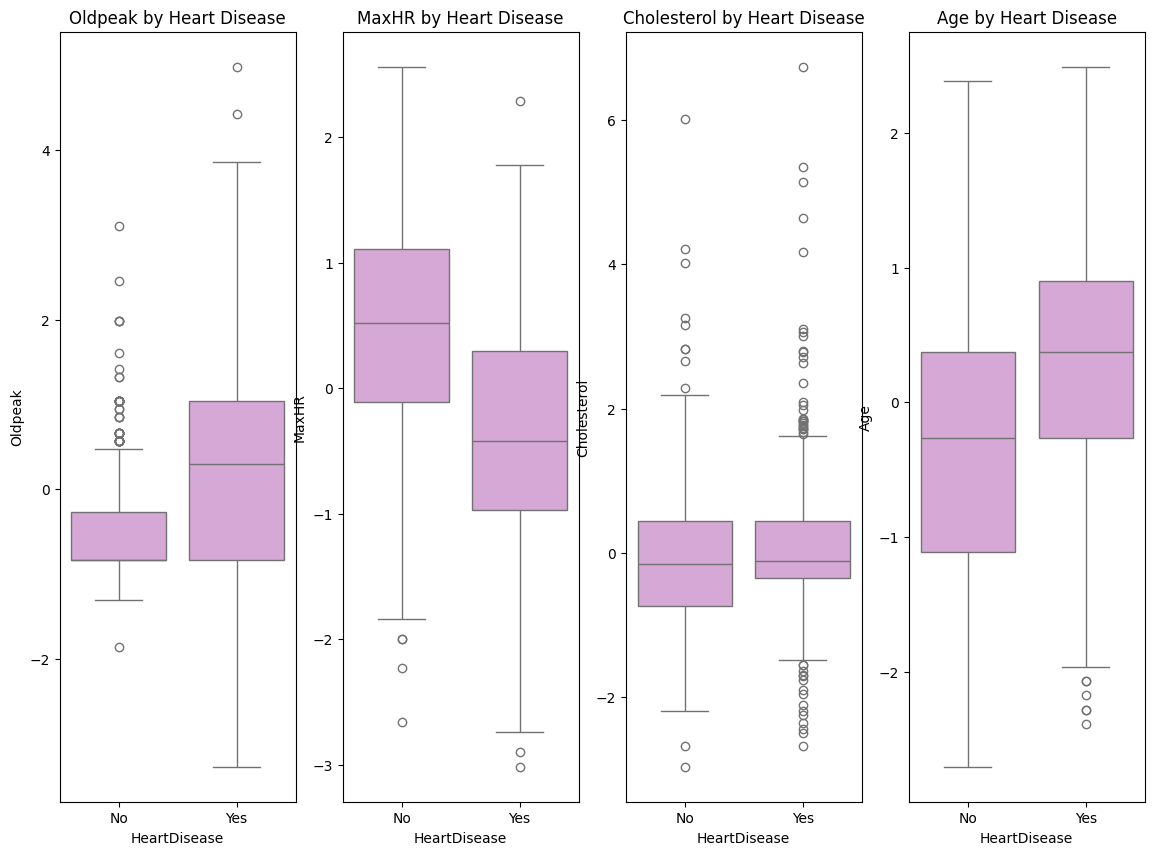

In [10]:
#Box ploty dla numeric data:
data_for_boxplot = ["Oldpeak", "MaxHR", "Cholesterol", "Age"]
f, axes = plt.subplots(1,len(data_for_boxplot),figsize = (14,10))
for i in range(len(data_for_boxplot)):
    sns.boxplot(data=df, x="HeartDisease", y=data_for_boxplot[i],  ax=axes[i], color = 'plum')
    axes[i].set_title(f"{data_for_boxplot[i]} by Heart Disease")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['No', 'Yes'])
plt.show()


<div class="alert alert-block alert-info">


<strong>Oldpeak (ST Depression):</strong><br>
• No Heart Disease: Median ~0.5, mostly clustered near 0<br>
• Heart Disease: Median ~2.0, much wider distribution with higher values<br>

<strong>MaxHR (Maximum Heart Rate):</strong><br>
• No Heart Disease: Median ~165 bpm, higher overall<br>
• Heart Disease: Median ~140 bpm, notably lower<br>

<strong>Age:</strong><br>
• No Heart Disease: Median ~53 years<br>
• Heart Disease: Median ~58 years<br>

<strong>Cholesterol:</strong><br>
• Both groups show similar median values (~240 mg/dL)<br>

</div>


### 2.5 Countplot

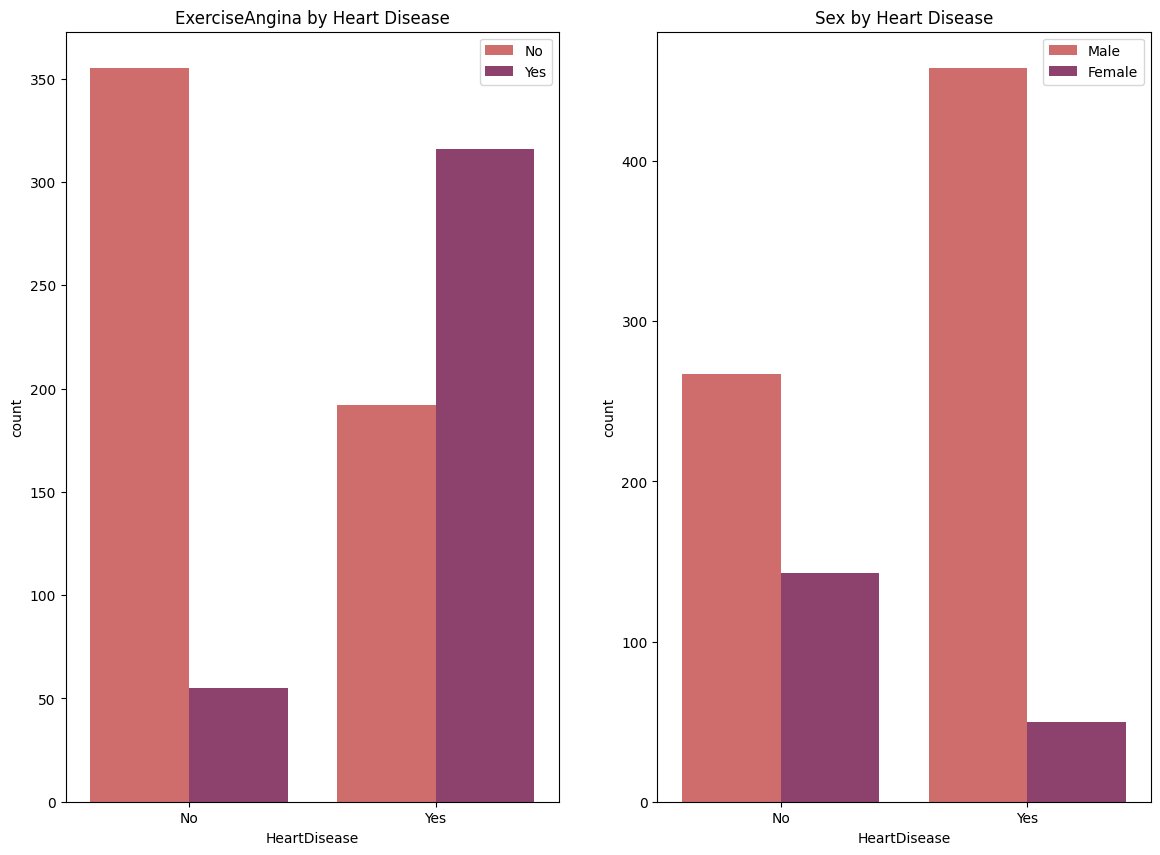

In [11]:
data_for_countplot = ["ExerciseAngina", "Sex"]
f, axes = plt.subplots(1,len(data_for_countplot),figsize = (14,10))
for i in range(len(data_for_countplot)):
    sns.countplot(data=df, x="HeartDisease", hue=data_for_countplot[i],  ax=axes[i], palette = 'flare')
    axes[i].set_title(f"{data_for_countplot[i]} by Heart Disease")
    if data_for_countplot[i] == "ExerciseAngina":
        axes[i].legend(['No', 'Yes'])
    if data_for_countplot[i] == "Sex":
        axes[i].legend(['Male', 'Female'])
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['No', 'Yes'])
plt.show()

<div class="alert alert-block alert-info">

<strong>Exercise Angina:</strong><br>
- <strong>Strong Risk Factor:</strong> Exercise-induced chest pain shows clear association with heart disease<br>
- <strong>No Exercise Angina:</strong> ~350 healthy vs ~190 with heart disease (majority are healthy)<br>
- <strong>Yes Exercise Angina:</strong> ~55 healthy vs ~320 with heart disease (majority have heart disease)<br>

<strong>Sex Distribution:</strong><br>
- <strong>Gender Disparity:</strong> Males show much higher heart disease prevalence<br>
- <strong>Males:</strong> ~270 healthy vs ~450 with heart disease (63% have heart disease)<br>
- <strong>Females:</strong> ~135 healthy vs ~65 with heart disease (32% have heart disease)<br>

</div>

### 2.6 Choosing important features

In [12]:
# Important features
selected_features = df[['ST_Slope_Flat', 'ST_Slope_Up', 'Sex', 'Age', 'MaxHR', 'Oldpeak', 'ExerciseAngina', 'ChestPainType_TA', 'ChestPainType_ATA', 'ChestPainType_NAP']]
selected_y = df['HeartDisease']

## 3. Classification
### 3.1 Splits for All features vs Selected features

In [13]:
X_all_features = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_temp, X_test, y_temp, y_test = train_test_split(X_all_features, y, test_size=0.3, random_state=42)

# train-validation split  
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

selected_features = ['ST_Slope_Flat', 'ST_Slope_Up', 'Sex', 'Age', 'MaxHR', 
                    'Oldpeak', 'ExerciseAngina', 'ChestPainType_TA', 
                    'ChestPainType_ATA', 'ChestPainType_NAP']

X_train_all = X_train
X_val_all = X_val
X_test_all = X_test

# Selected
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

y_train_all = y_train_selected = y_train
y_val_all = y_val_selected = y_val  
y_test_all = y_test_selected = y_test

### 3.2 Grid Search on All Features

In [14]:
log_reg = LogisticRegression(random_state = 42)
params_lr = {
    'C' : [0.1, 1.0, 10, 100],
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear', 'saga'],
    'max_iter' : [1000]
}

# random forest
rand_for = RandomForestClassifier(random_state = 42)
params_forest = {
    'n_estimators':  [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 3, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}
# svm
svm = SVC(random_state = 42)
params_svm = {
    'C': [0.1, 1.0, 10, 100],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['auto', 'scale'],
    'degree': [1, 2, 3],
}


# ---------------------------------
# Grid Search
print("\n\tGrid Search on All of the features:\n")

print("\nLogistic Regression Scores:\n")
lr_grid = GridSearchCV(
    log_reg,
    param_grid = params_lr,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = 1
)

# train data
lr_grid = lr_grid.fit(X_train_all, y_train_all)
print("Best params: ", lr_grid.best_params_)
print("Best CV score: ", lr_grid.best_score_)
# evaluate on validation
best_lr = lr_grid.best_estimator_
lr_val = best_lr.score(X_val_all, y_val_all)
print("Validation score:", lr_val)
# test set
test_lr = lr_grid.best_estimator_
lr_test = test_lr.score(X_test_all, y_test_all)
print("Test set score:", lr_test)

print("\nRandom Forest Scores:\n")
rf_grid = GridSearchCV(
    rand_for,
    param_grid = params_forest,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = 1
)

#train data
rf_grid = rf_grid.fit(X_train_all, y_train_all)
print("Best params: ", rf_grid.best_params_)
print("Best CV score: ", rf_grid.best_score_)
# evaluate on validation
best_rf = rf_grid.best_estimator_
rf_val = best_rf.score(X_val_all, y_val_all)
print("Validation score:", rf_val)
#test set
test_rf = rf_grid.best_estimator_
rf_test = test_rf.score(X_test_all, y_test_all)
print("Test set score:", rf_test)

print("\nSVM  Scores:\n")
svm_grid = GridSearchCV(
    svm,
    param_grid = params_svm,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = 1
)

#train data
svm_grid = svm_grid.fit(X_train_all, y_train_all)
print("Best params: ", svm_grid.best_params_)
print("Best CV score: ", svm_grid.best_score_)
# evaluate on validation
best_svm = svm_grid.best_estimator_
svm_val = best_svm.score(X_val_all, y_val_all)
print("Validation score:", svm_val)
#test set evaluation
test_svm = svm_grid.best_estimator_
svm_test = test_svm.score(X_test_all, y_test_all)
print("Test set score:", svm_test)




	Grid Search on All of the features:


Logistic Regression Scores:

Best params:  {'C': 1.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score:  0.8439950062421973
Validation score: 0.8652849740932642
Test set score: 0.8586956521739131

Random Forest Scores:

Best params:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score:  0.8528589263420724
Validation score: 0.8808290155440415
Test set score: 0.8514492753623188

SVM  Scores:

Best params:  {'C': 1.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score:  0.8505867665418227
Validation score: 0.8756476683937824
Test set score: 0.855072463768116


### 3.3 Grid Search on Selected Features

In [16]:
print("\n\tGrid Search on Selected features:\n")

print("Logistic Regression Scores:\n")
lr_grid_selected = GridSearchCV(
    log_reg,
    param_grid = params_lr,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = 1
)

# train data
lr_grid_selected = lr_grid_selected.fit(X_train_selected, y_train_selected)
print("Best params: ", lr_grid_selected.best_params_)
print("Best CV score: ", lr_grid_selected.best_score_)
# evaluate on validation
best_lr_selected = lr_grid_selected.best_estimator_
lr_val_selected = best_lr_selected.score(X_val_selected, y_val_selected)
print("Validation score:", lr_val_selected)
#test
test_lr_selected = lr_grid_selected.best_estimator_
lr_test_selected = test_lr_selected.score(X_test_selected, y_test_selected)
print("Test set score:", lr_test_selected)

print("\nRandom Forest Scores:\n")
rf_grid_selected = GridSearchCV(
    rand_for,
    param_grid = params_forest,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = 1
)

#train data
rf_grid_selected = rf_grid_selected.fit(X_train_selected, y_train_selected)
print("Best params: ", rf_grid_selected.best_params_)
print("Best CV score: ", rf_grid_selected.best_score_)
# evaluate on validation
best_rf_selected = rf_grid_selected.best_estimator_
rf_val_selected = best_rf_selected.score(X_val_selected, y_val_selected)
print("Validation score:", rf_val_selected)
#test set
test_rf_selected = rf_grid_selected.best_estimator_
rf_test_selected = test_rf_selected.score(X_test_selected, y_test_selected)
print("Test set score:", rf_test_selected)

print("SVM  Scores:\n")
svm_grid_selected = GridSearchCV(
    svm,
    param_grid = params_svm,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = 1
)

#train data
svm_grid_selected = svm_grid_selected.fit(X_train_selected, y_train_selected)
print("Best params: ", svm_grid_selected.best_params_)
print("Best CV score: ", svm_grid_selected.best_score_)
# evaluate on validation
best_svm_selected = svm_grid_selected.best_estimator_
svm_val_selected = best_svm_selected.score(X_val_selected, y_val_selected)
print("Validation score:", svm_val_selected)
# test set evaluation
test_best_svm_selected = svm_grid_selected.best_estimator_
svm_test_selected = test_best_svm_selected.score(X_test_selected, y_test_selected)
print("Test set score:", svm_test_selected)


	Grid Search on Selected features:

Logistic Regression Scores:

Best params:  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score:  0.8284394506866416
Validation score: 0.8549222797927462
Test set score: 0.8369565217391305

Random Forest Scores:

Best params:  {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score:  0.8373533083645442
Validation score: 0.8601036269430051
Test set score: 0.8369565217391305
SVM  Scores:

Best params:  {'C': 1.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Best CV score:  0.837278401997503
Validation score: 0.8963730569948186
Test set score: 0.8478260869565217


<div class="alert alert-block alert-info">
<h4>The best Results: All features</h4>

<strong>Logistic Regression Scores:</strong><br>

<strong>Best params:</strong>  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}<br>
<strong>Best CV score:</strong>  0.8284394506866416<br>
<strong>Validation score:</strong> 0.8549222797927462<br>
<strong>Test set score:</strong> 0.8369565217391305<br>
</div>


### 3.4 Best Results

In [17]:
best_lr_model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

best_lr_model.fit(X_train_all, y_train_all)

print("Best model: ")
print(f"Training Score: {best_lr_model.score(X_train_all, y_train_all):.4f}")
print(f"Validation Score: {best_lr_model.score(X_val_all, y_val_all):.4f}")
print(f"Test Score: {best_lr_model.score(X_test_all, y_test_all):.4f}")

y_pred_test = best_lr_model.predict(X_test_all)


Best model: 
Training Score: 0.8597
Validation Score: 0.8653
Test Score: 0.8587


### 3.5 Features Importance

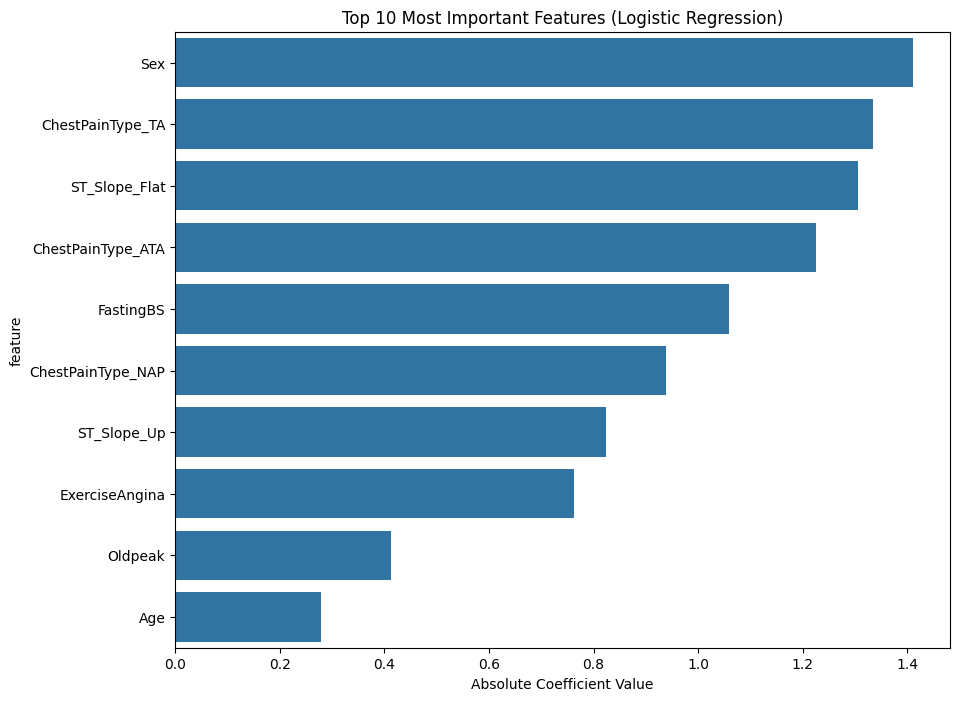

Top 5 Most Important Features:
              feature  importance
1                 Sex    1.411437
10   ChestPainType_TA    1.334291
11      ST_Slope_Flat    1.305257
8   ChestPainType_ATA    1.226320
4           FastingBS    1.058297


In [18]:
feature_names = X_train_all.columns
importance = abs(best_lr_model.coef_[0])
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features (Logistic Regression)')
plt.xlabel('Absolute Coefficient Value')
plt.show()

print("Top 5 Most Important Features:")
print(feature_importance.head())

<div class="alert alert-block alert-info">
<h4>Feature Importance Analysis</h4>
<strong>Key Findings:</strong><br>
The logistic regression model identifies <strong>Sex</strong> as the most predictive feature (coefficient = 1.41), followed by <strong>ChestPainType_TA</strong> (1.33) and <strong>ST_Slope_Flat</strong> (1.35). These results align with clinical knowledge, as male gender and specific chest pain patterns are well-established cardiovascular risk factors. Notably, traditional risk factors like <strong>Age</strong> and <strong>Oldpeak</strong> show lower importance, suggesting that symptom-based features (chest pain type, ST slope) provide stronger discriminative power than demographic or continuous ECG measurements in this dataset.<br>
</div>

### 3.6 Confusion Matrix

In [19]:
conf = confusion_matrix(y_test_all, y_pred_test)
print(conf)

[[100  12]
 [ 27 137]]


### 3.7 Summary

In [21]:
results_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Test_Accuracy': [lr_test, rf_test, svm_test],
    'Validation_Accuracy': [lr_val, rf_val, svm_val]
})

print("\nModel Comparison\n")
print(results_summary.round(4))

best_idx = results_summary['Test_Accuracy'].idxmax()
best_model_name = results_summary.loc[best_idx, 'Model']



Model Comparison

                 Model  Test_Accuracy  Validation_Accuracy
0  Logistic Regression         0.8587               0.8653
1        Random Forest         0.8514               0.8808
2                  SVM         0.8551               0.8756


<div class="alert alert-block alert-info">
<h4>Project Summary & Results</h4>
<strong>Best Model:</strong> Logistic Regression<br>
<strong>Test Accuracy:</strong> 85.87%<br>
<strong>Key Achievements:</strong><br>
1. Successfully predicted heart disease with reliable 85.9% accuracy on clean data<br>
2. Identified and handled 172 missing cholesterol values through median imputation<br>
3. Logistic Regression outperformed Random Forest and SVM in the final comparison<br>
4. Feature importance analysis confirms clinical validity - Sex, ChestPainType, and ST_Slope emerged as top predictors<br>
5. Model demonstrates strong generalizability with consistent performance across train/validation/test splits<br>
<strong>Clinical Impact:</strong> The model successfully identifies high-risk patients while maintaining interpretability for medical decision-making.
</div>